# Target Detection for Plastic

This notebook demonstrates the application of matched filters for target detection in hyperspectral imagery.  We'll be using AVIRIS classic imagery for this demonstration, which will focus on identifying the uncapped areas of the El Sobrante landfill in Corona, CA—the largest landfill in the US covered by an AVIRIS flight—under the assumption that there is a high concentration of plastic waste, including garbage bags, in those areas.

We will proceed by

1. identifying a desirable AVIRIS image,
1. loading reference spectra, and
1. applying a matched filter to detect the presence of plastic.

## Select AVIRIS scene

Here, we look for the largest available landfill and choose the most recent AVIRIS scene containing it.  We will find a window that covers the target landfill, and we will find a "control" window that we can use to characterize the background signal.

In [1]:
from copy import deepcopy
import ftplib
from functools import partial
import math
from multiprocessing import Pool
import os
from os.path import basename, dirname
import re
from urllib.parse import urlparse

import fastkml
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
import rasterio.features as rfeat
import rasterio.warp as rwarp
import scipy
import shapely
from tqdm.autonotebook import tqdm
import xml.dom as dom

from hyperspectral.spectra import Spectrum, SpectralLibrary

%matplotlib inline

Package `lxml` missing. Pretty print will be disabled
/home/jpolchlopek/.python_envs/nasa/lib/python3.6/site-packages/ipykernel/__main__.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Load and repair AVIRIS table

Note that some of the KML geometry descriptions in the JPL-provided source table are improperly specified.

In [2]:
def kml_poly_to_geom(kml_poly):
    try:
        # Not all KML polygons are correct (missing LinearRing tag); grab coords directly
        kmldom = dom.minidom.parseString('<?xml version="1.0" ?><kml xmlns="http://www.opengis.net/kml/2.2"><Document><Placemark>'+kml_poly+'</Placemark></Document></kml>')
        coords = kmldom.getElementsByTagName('outerBoundaryIs')[0].getElementsByTagName('coordinates')[0]
        kml = fastkml.KML()
        kml.from_string('<?xml version="1.0" ?><kml xmlns="http://www.opengis.net/kml/2.2"><Document><Placemark><Polygon><outerBoundaryIs><LinearRing>'+coords.toxml()+'</LinearRing></outerBoundaryIs></Polygon></Placemark></Document></kml>')
    except:
        return None
    return next(next(kml.features()).features()).geometry

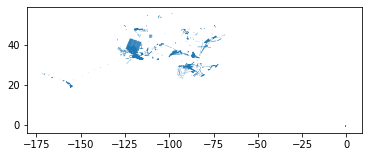

In [3]:
aviris = pd.read_csv('data/aviris-flight-lines.csv')
aviris = gp.GeoDataFrame(aviris, geometry=[kml_poly_to_geom(poly) for poly in aviris['kml_poly']]).set_crs(epsg=4326)
aviris.plot()

### Identify scenes with L2 data

In [4]:
ftpurl = urlparse(aviris.iloc[0].link_ftp)
ftp = ftplib.FTP(ftpurl.hostname)
ftp.login(ftpurl.username, ftpurl.password)

l2 = []
for yy in set(aviris['YY']):
    ftp.cwd('y{}_data'.format(str(yy).zfill(2)))
    l2 = l2 + list(filter(lambda s: '_refl' in s, ftp.nlst()))
    ftp.cwd('..')

ftp.close()

l2 = [re.sub('_refl\.tar\.gz', '', n) for n in l2]
l2df = pd.DataFrame({'Name': l2, 'has_l2': [True] * len(l2)}).set_index('Name')

In [5]:
aviris_l2 = aviris.join(l2df, on='Name', how='inner')
len(aviris_l2)

1554

### Choose target area

Using an extract of landfill polygons from OpenStreetMap, we sort the landfills by area and join them to the list of L2 AVIRIS imagery.

In [6]:
landfills = gp.read_file("data/aviris_landfills.gpkg").set_crs(epsg=4326)
landfills['area'] = landfills.geometry.to_crs(epsg=5070).area
landfills['lfgeom'] = landfills.geometry
landfills

,id_left,id_right,name,geometry,area,lfgeom
0,way/25027718,aviris_f171221t01p00r09_sc01,None,"POLYGON ((-121.69279 38.59065, -121.67691 38.5...",1.622864e+06,"POLYGON ((-121.69279 38.59065, -121.67691 38.5..."
1,way/25880989,aviris_f171221t01p00r09_sc01,None,"POLYGON ((-121.70367 38.55320, -121.70377 38.5...",5.158543e+04,"POLYGON ((-121.70367 38.55320, -121.70377 38.5..."
2,way/32704348,aviris_f171221t01p00r09_sc01,None,"POLYGON ((-121.17448 38.50409, -121.18004 38.5...",1.477941e+06,"POLYGON ((-121.17448 38.50409, -121.18004 38.5..."
3,way/27284827,aviris_f180601t01p00r06_sc01,None,"POLYGON ((-122.15237 37.64211, -122.15234 37.6...",1.549185e+05,"POLYGON ((-122.15237 37.64211, -122.15234 37.6..."
4,way/27284829,aviris_f180601t01p00r06_sc01,None,"POLYGON ((-122.15419 37.64588, -122.15409 37.6...",2.424573e+05,"POLYGON ((-122.15419 37.64588, -122.15409 37.6..."
...,...,...,...,...,...,...
260,way/842826369,aviris_f170420t01p00r05_sc01,None,"POLYGON ((-82.84530 35.11884, -82.84436 35.118...",2.747379e+05,"POLYGON ((-82.84530 35.11884, -82.84436 35.118..."
261,way/842835292,aviris_f170420t01p00r05_sc01,Buncombe County Landfill,"POLYGON ((-82.63889 35.72747, -82.63966 35.727...",6.774254e+05,"POLYGON ((-82.63889 35.72747, -82.63966 35.727..."
262,way/861187079,aviris_f080709t01p00r13_sc01,Former Landfill,"POLYGON ((-86.18765 42.82224, -86.18775 42.819...",1.734744e+05,"POLYGON ((-86.18765 42.82224, -86.18775 42.819..."
263,way/867846377,aviris_f061002t01p00r10_sc01,Red Cliff Waste & Recycling Transfer Station,"POLYGON ((-90.79126 46.89637, -90.79126 46.895...",1.788899e+04,"POLYGON ((-90.79126 46.89637, -90.79126 46.895..."


In [7]:
merged = gp.sjoin(aviris_l2, landfills)
selection = merged.sort_values(['area', 'Name'], ascending=False).iloc[0]
selection

Name                                                       f190812t01p00r07
Site Name                                                           Caltech
NASA Log                                                                NaN
Investigator                                                   Kalashnikova
Comments                                                              clear
Flight Scene                                          f190812t01p00r07_sc01
Date                                                                8/12/19
RDN Ver                                                                   e
Scene                                                                  sc01
GEO Ver                                                                 ort
YY                                                                       19
Tape                                                                    t01
Flight ID                                                        f190812t01
Flight      

### Fetch AVIRIS scene (Run only once per selection!)

The following section will fetch the 5GB scene from the source FTP server and unpack it.  As this is a time-consuming step, be sure not to run more than once per scene.

In [ ]:
filename = '{}_refl.tar.gz'.format(selection.Name)
filename

In [ ]:
ftpurl = urlparse(selection.link_ftp)
ftpurl

ftp = ftplib.FTP(ftpurl.hostname)
ftp.login(ftpurl.username, ftpurl.password)
ftp.cwd(dirname(ftpurl.path))

with tqdm(total=ftp.size(filename)) as pb:
    with open(os.path.join('data', filename), 'wb') as f:
        def cb(data):
            f.write(data)
            pb.update(len(data))
        
        ftp.retrbinary('RETR ' + filename, cb)
    
ftp.close()

In [ ]:
os.system('tar xzf data/{} -C data'.format(filename))

### Load raster data

Create a Rasterio data source for the target scene

In [8]:
refl_dir, refl_file = [(d, list(filter(lambda f: '_corr' in f and not f.endswith('.hdr'), files))[0]) for (d, sds, files) in os.walk('data') if any(list(filter(lambda f: re.match('{}.*_corr.*'.format(selection.Name), f), files)))][0]
refl_dir, refl_file

('data/f190812t01p00r07_rfl_v1l1', 'f190812t01p00r07_corr_v1l1_img')

In [9]:
ds = rio.open(os.path.join(refl_dir, refl_file))

#### Visualize landfill footprint

Window(col_off=147, row_off=9116, width=212, height=148)


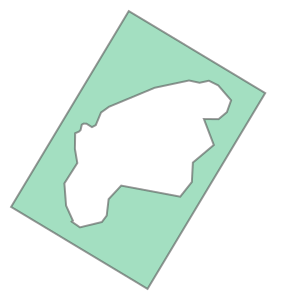

In [10]:
trans = partial(pyproj.transform, pyproj.Proj(init='EPSG:4326'), pyproj.Proj(ds.crs.to_string()))
footprint_utm = shapely.ops.transform(trans, selection.lfgeom)
xy_of = partial(rio.transform.xy, ds.transform)
(r, c) = ds.shape

w = rfeat.geometry_window(ds, [footprint_utm], rotated=True, pad_x=1, pad_y=1)
print(w)
shapely.ops.transform(xy_of, shapely.geometry.Polygon(
    [(w.row_off,w.col_off), 
     (w.row_off + w.height - 1,w.col_off), 
     (w.row_off + w.height - 1, w.col_off + w.width - 1), 
     (w.row_off,w.col_off + w.width - 1), 
     (w.row_off,w.col_off)])).difference(footprint_utm)

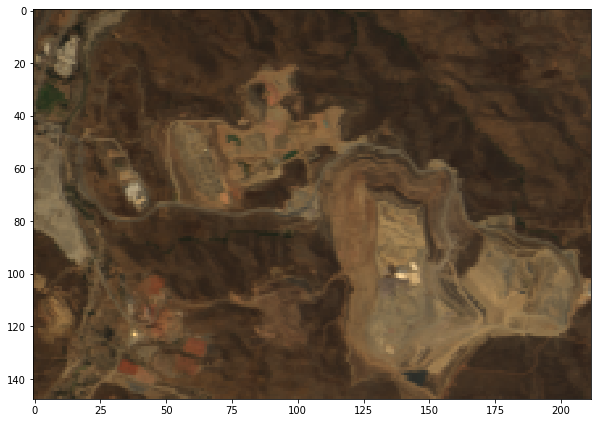

In [11]:
lf_rgb = ds.read([30,20,10], window=w)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(np.dstack(lf_rgb)/np.max(lf_rgb))

#### Identify clear pixels

In order to characterize the noise model for the sensor, we need signal-free pixels.  The following selects a nearby window that is mostly undisturbed landscape.

Window(col_off=253.0, row_off=8968, width=212, height=148)


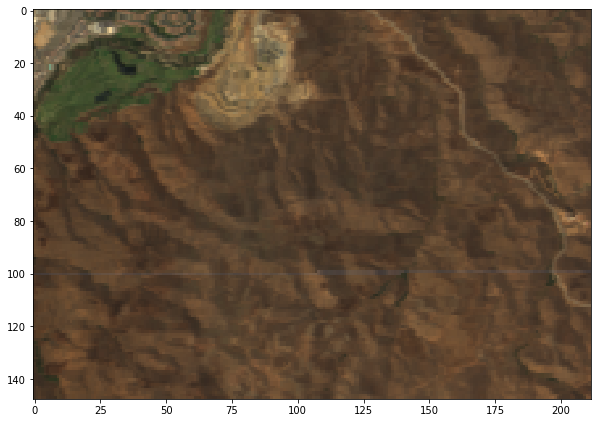

In [12]:
w0 = rio.windows.Window(w.col_off + w.width/2, w.row_off - w.height, w.width, w.height)
print(w0)
lf_rgb = ds.read([30,20,10], window=w0)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(np.dstack(lf_rgb)/np.max(lf_rgb))

## Construct Reference Spectral Library

For this application, we need to have spectral samples describing the substances of interest.  We will include a spectrum published on ECOSIS of marine-gathered microplastics, which is the most readily-accessible sample we could find that is likely to capture environmentally-weathered plastics.  Find this spectrum at https://ecosis.org/package/spectral-reflectance-of-dry-and-wet-marine-harvested-microplastics-from-kamilo-point--pacific-ocean, and download the file into the `data/` directory, electing to "include linked ancillary metadata in download".

Also used by this example is an asphalt material spectrum included in the ECOSTRESS spectral library.  This will later demonstrate some limitations with the target detection algorithm.  

In [13]:
def ecosis_row_to_spectrum(r, type_, class_):
    data = list(map(lambda kv: (int(kv[0]), kv[1]), filter(lambda kv: kv[0][0] in '0123456789', r.items())))
    metadata = {k:v for k,v in r.items() if k[0] not in '0123456789'}
    xs = list(map(lambda kv: kv[0], data))
    ys = list(map(lambda kv: kv[1], data))
    if 'wavelengths' in metadata.keys():
        metadata['X Units'] = metadata['wavelengths']
    if 'column_units' in metadata.keys():
        metadata['Y Units'] = metadata['column_units']
    return Spectrum(metadata['description'], type_, class_, min(xs), max(xs), len(xs), metadata, xs, ys)

In [14]:
marine = pd.read_csv('data/spectral-reflectance-of-dry-and-wet-marine-harvested-microplastics-from-kamilo-point--pacific-ocean.csv')
mean_plastic = ecosis_row_to_spectrum(marine.iloc[4], 'manmade', 'plastic')

In [15]:
_,_,files = next(os.walk('ECOSTRESS'))
files = list(map(lambda s: 'ECOSTRESS/' + s, filter(lambda s: s.endswith('.spectrum.txt'), files)))

with Pool() as p:
    ecostress_raw = list(tqdm(p.imap(Spectrum.parse_ECOSTRESS, files), total=len(files)))

ecostress = SpectralLibrary(list(filter(lambda s: s['Wavelength Range'] != 'TIR', ecostress_raw)))

In [16]:
road_materials = ecostress.filter_spectra(lambda s: s.type_.lower() == "manmade" and s.class_.lower() == "road")

In [17]:
spec = road_materials.spectra[3]
asphalt = Spectrum(spec.name, spec.class_, spec.type_, spec.x_range[0], spec.x_range[1], spec.n_samples, deepcopy(spec.info), np.array([λ * 1000 for λ in spec.x]), np.array([λ/100 for λ in spec.y]))
del spec
asphalt.info['X Units'] = 'Nanometers'

### Prepare Reference Spectrum

Note that wavelengths are in the ranges 1350–1410, 1800–1949, 2351–2500 correspond to atmospheric water absorption and will be dropped below.

Start by identifying the frequencies of the AVIRIS bands from the image metadata.

In [18]:
band_freqs = sorted([ (int(kv[0].split('_')[1]), float(kv[1].split(' ')[0])) for kv in ds.tags().items() if any(num in kv[0] for num in '0123456789')])

In [19]:
reference_spectra = SpectralLibrary([mean_plastic, asphalt])
reference_spectra.regularize([bf[1] for bf in band_freqs], source_bands=[bf[0] for bf in band_freqs])

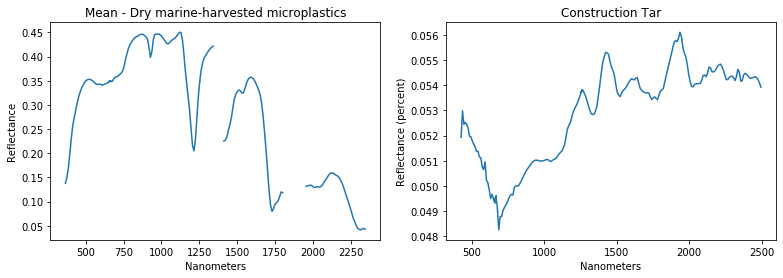

In [20]:
fig, axes = plt.subplots(1,2,figsize=(13,4))
reference_spectra.spectra[0].plot(ax=axes[0])
reference_spectra.spectra[1].plot(ax=axes[1])

In [ ]:
landfill = np.dstack(ds.read(reference_spectra.source_bands, window=w))
clear = np.dstack(ds.read(reference_spectra.source_bands, window=w0))
np.savez('data/landfill_clear_plastic.npz', landfill, clear, reference_spectra.spectra[0].y)

In [21]:
to_drop = reference_spectra.invalid_bands()
to_drop.update([104, 112, 113, 146]) # Manually exlude other problematic bands
reference_spectra.drop_bands(to_drop)

## Dimensionality Reduction

This section reduces the dimension of the spectral data through a robust PCA, which is tolerant of outliers.  The number of basis vectors are chosen to be sufficient to represent the target plastic spectrum with good fidelity.

In [22]:
from hyperspectral.math import rpca_grid, goodness_of_fit, project_data, whitening_matrix, whiten
from hyperspectral.target import normalized_matched_filter

In [23]:
aoi = np.dstack(ds.read(reference_spectra.source_bands, window=w))
aoi_median = np.median(aoi.reshape((w.width * w.height, len(reference_spectra.source_bands))).transpose(),axis=1)
aoi = aoi - aoi_median

In [24]:
def fit_criteria(signal, r2):
    def test(B):
        r2_actual, _ = goodness_of_fit(B, signal)
        return r2_actual > r2
    return test

In [25]:
soi = 0

In [26]:
plastic_basis = rpca_grid(aoi.reshape((w.width * w.height, len(reference_spectra.source_bands))).transpose(), 100, sufficient=fit_criteria(reference_spectra.spectra[soi].y - aoi_median, 0.95))

##### Signal of interest projection into target space

This is a sanity check that the basis we found is capable of representing the signal we are interested in.  Large projection errors would compound the difficulty of target detection.

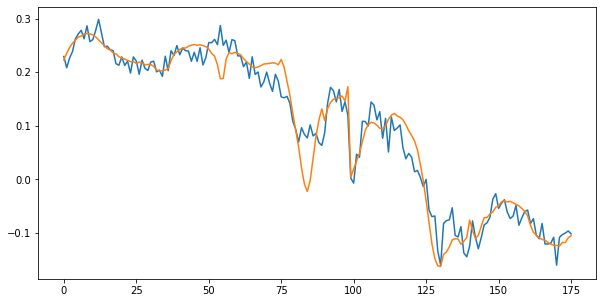

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
_, proj = goodness_of_fit(plastic_basis, reference_spectra.spectra[soi].y - aoi_median, ax=ax)

##### Arbitrary pixel representation in target space

Another simple sanity check to ensure that the found basis does a good job capturing the image pixels.  We can see below that the goodness-of-fit measure for the whole image is generally very good.

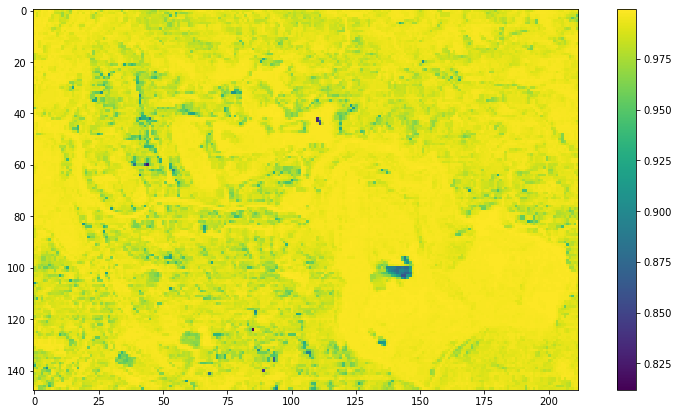

In [28]:
quality = np.zeros((w.height, w.width))
for r in tqdm(range(w.height)):
    for c in range(w.width):
        quality[r,c] = goodness_of_fit(plastic_basis, aoi[r,c,:])[0]

fig, ax = plt.subplots(figsize=(14,7))
plot = ax.imshow(quality)
fig.colorbar(plot)
plt.show()

### Characterize sensor noise

In [29]:
clear = np.dstack(ds.read(reference_spectra.source_bands, window=w0))
clutter = project_data(clear, proj=proj)
clutter_samples = clutter.reshape(clutter.shape[0] * clutter.shape[1], clutter.shape[2])
clutter_mean = np.mean(clutter_samples, axis=0)
clutter_cov = np.cov(clutter_samples, rowvar=False)

### Perform matched filter

In [30]:
aoi_reduced = project_data(aoi, proj=proj)
signal = project_data(reference_spectra.spectra[soi].y - aoi_median, proj=proj)

In [31]:
detected_plastic = normalized_matched_filter(aoi_reduced, signal, clutter_cov)

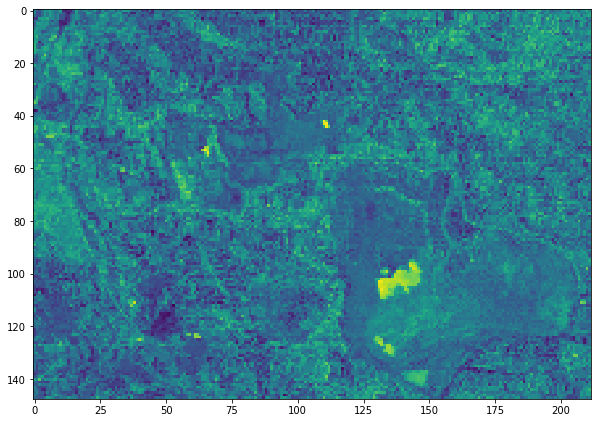

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(detected_plastic)

In [33]:
other_signal = project_data(reference_spectra.spectra[1-soi].y - aoi_median, proj=proj)
detected_asphalt = normalized_matched_filter(aoi_reduced, other_signal, clutter_cov)

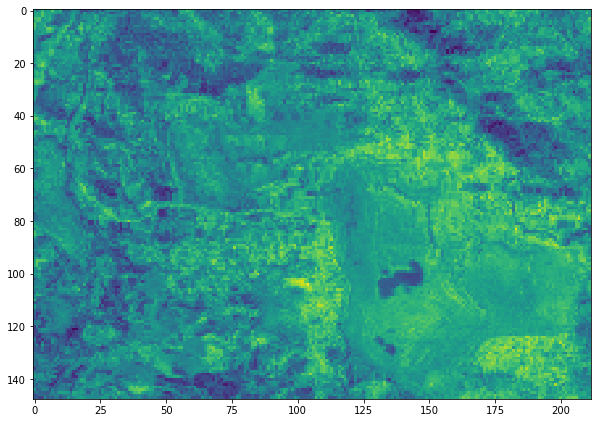

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(detected_asphalt)

##### Examine reproducability of other signal in present basis

0.9986223806093568

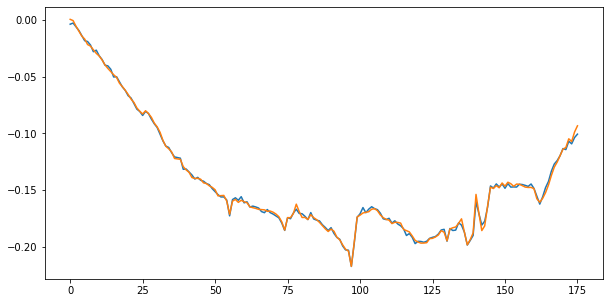

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
goodness_of_fit(plastic_basis, reference_spectra.spectra[1-soi].y - aoi_median, ax=ax)[0]

The close approximation of this (centered) spectrum in the found basis indicates that we should have found a better match, but may also indicate that the signal we are attempting to detect is so similar in shape to the content of the source image, that it might be difficult to separate from the observed spectra.